## Imports etc.

In [1]:
#Imports
import time
import numpy as np
import yaml
import os
import pickle
import scipy
import pylab
import matplotlib.pyplot as plt
from pylab import figure, axes, pie, title, show
import astropy.io.fits as pyfits
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord, Galactocentric
from astropy_healpix import HEALPix
import astropy.units as u
import healpy as hp

## Load classifier

In [2]:
class surveySelectionFunction:
    
    def __init__(self, config_file):
        self.config = yaml.load(open(config_file))
        self.algorithm = self.config['operation']['algorithm']
        self.classifier = None
        self.loadClassifier()

    def loadClassifier(self):
        if os.path.exists(self.config[self.algorithm]['classifier'] + '.gz') and not os.path.exists(self.config[self.algorithm]['classifier']):
            os.system('gunzip -k %s.gz'%(self.config[self.algorithm]['classifier']))
        reader = open(self.config[self.algorithm]['classifier'])
        classifier_data = ''.join(reader.readlines())
        reader.close()
        self.classifier = pickle.loads(classifier_data)
        
    def predict(self, **kwargs):
        assert self.classifier is not None, 'ERROR'    
        x_test = []
        for key, operation in self.config['operation']['params_intrinsic']:
            assert operation.lower() in ['linear', 'log'], 'ERROR'
            if operation.lower() == 'linear':
                x_test.append(kwargs[key])
            else:
                x_test.append(np.log10(kwargs[key]))

        x_test = np.vstack(x_test).T
        #pred = self.classifier.predict(x_test)#[:,1]
        pred = self.classifier.predict_proba(x_test)[:,1]
        return pred

In [3]:
DES_config_file = os.getcwd() + '/des_y3a2_survey_selection_function.yaml'
DES_ssf = surveySelectionFunction(DES_config_file)
DES_ssf.loadClassifier()

/usr/local/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
PS1_config_file = os.getcwd() + '/PS1_DR1_survey_selection_function.yaml'
PS1_ssf = surveySelectionFunction(PS1_config_file)
PS1_ssf.loadClassifier()

## Load satellite data

In [5]:
data_sim = pyfits.open('lvdb_v2.fits')
lvdb = data_sim[1].data

In [6]:
PS1_confirmed_sats = ['Leo I', 'Leo II', 
            'Draco', 'Ursa Minor', 'Sextans', 'Canes Venatici I', 'Bootes I', 'Ursa Major II',
            'Coma Berenices I', 'Sagittarius II', 'Segue 1', 'Segue 2', 'Canes Venatici II', 'Draco II',
            'Triangulum II', 'Ursa Major I', 'Hercules I'] 
    
PS1_sats_all = ['Leo I', 'Leo II', 
            'Draco', 'Ursa Minor', 'Sextans', 'Canes Venatici I', 'Bootes I', 'Ursa Major II',
            'Coma Berenices I', 'Sagittarius II', 'Segue 1', 'Segue 2', 'Canes Venatici II', 'Draco II',
            'Triangulum II', 'Ursa Major I', 'Hercules I', 'Crater II', 'Leo IV', 'Aquarius II', 'Cetus II',
               'Bootes II', 'Leo V', 'Bootes III', 'Columba I', 'Pisces II', 'Antlia', 'Virgo I', 'Pegasus III',
               'Cetus III'] 
    
MW_Mv_PS1 = []
MW_r_PS1 = []
MW_ra_PS1 = []
MW_dec_PS1 = []
MW_r12_PS1 = []

for name in PS1_sats_all:
    MW_Mv_PS1.append(lvdb[lvdb['name'] == name]['m_v'][0])
    MW_r_PS1.append(lvdb[lvdb['name'] == name]['distance_kpc'][0])
    MW_r12_PS1.append(np.radians(lvdb[lvdb['name'] == name]['rhalf'][0]/60.)*lvdb[lvdb['name'] == name]['distance_kpc'][0])
    MW_ra_PS1.append(lvdb[lvdb['name'] == name]['ra'][0])
    MW_dec_PS1.append(lvdb[lvdb['name'] == name]['dec'][0])
    
    
MW_Mv_PS1 = np.asarray(MW_Mv_PS1)
MW_r_PS1 = np.asarray(MW_r_PS1)
MW_ra_PS1 = np.asarray(MW_ra_PS1)
MW_dec_PS1 = np.asarray(MW_dec_PS1)
MW_r12_PS1 = np.asarray(MW_r12_PS1)

In [7]:
#Literature values not in LVDB 
MW_Mv_PS1[-1] = -2.4
MW_Mv_PS1[-11] = -4.36
MW_Mv_PS1[-13] = -8.2

MW_r12_PS1[-1] = 0.09
MW_r12_PS1[-7] = np.radians(0.5/60.)*lvdb[lvdb['name']=='Bootes III']['distance_kpc']
MW_r12_PS1[-11] = 0.16
MW_r12_PS1[-13] = 1.1

In [8]:
DES_dwarfs_confirmed = ['Large Magellanic Cloud', 'Small Magellanic Cloud', 'Fornax', 'Sculptor', 'Reticulum II', 'Eridanus II', 'Grus II', 'Tucana II',
                             'Horologium I', 'Tucana III', 'Tucana IV', 'Phoenix II', 'Cetus II', 'Horologium II',
                             'Tucana V', 'Grus I', 'Columba I', 'Pictor I', 'Eridanus III']

DES_dwarfs_all = ['Large Magellanic Cloud', 'Small Magellanic Cloud', 'Fornax', 'Sculptor', 'Reticulum II', 
                  'Eridanus II', 'Grus II', 'Tucana II', 'Horologium I', 'Tucana III', 'Tucana IV', 'Phoenix II', 
                  'Cetus II', 'Horologium II', 'Tucana V', 'Grus I', 'Columba I', 'Pictor I', 'Eridanus III', 
                  'Reticulum III', 'Kim 2', 'Indus II', 'Cetus III']

MW_Mv_DES = []
MW_r_DES = []
MW_ra_DES = []
MW_dec_DES = []
MW_r12_DES = []

for name in DES_dwarfs_all:
    if name == 'Pictor I':
        MW_Mv_DES.append(lvdb[lvdb['name'] == name]['m_v'][1])
        MW_r_DES.append(lvdb[lvdb['name'] == name]['distance_kpc'][1])
        MW_r12_DES.append(np.radians(lvdb[lvdb['name'] == name]['rhalf'][1]/60.)*lvdb[lvdb['name'] == name]['distance_kpc'][1])
        MW_ra_DES.append(lvdb[lvdb['name'] == name]['ra'][1])
        MW_dec_DES.append(lvdb[lvdb['name'] == name]['dec'][1])
        continue
    else:
        MW_Mv_DES.append(lvdb[lvdb['name'] == name]['m_v'][0])
        MW_r_DES.append(lvdb[lvdb['name'] == name]['distance_kpc'][0])
        MW_r12_DES.append(np.radians(lvdb[lvdb['name'] == name]['rhalf'][0]/60.)*lvdb[lvdb['name'] == name]['distance_kpc'][0])
        MW_ra_DES.append(lvdb[lvdb['name'] == name]['ra'][0])
        MW_dec_DES.append(lvdb[lvdb['name'] == name]['dec'][0])
        
MW_Mv_DES = np.asarray(MW_Mv_DES)
MW_r_DES = np.asarray(MW_r_DES)
MW_ra_DES = np.asarray(MW_ra_DES)
MW_dec_DES = np.asarray(MW_dec_DES)
MW_r12_DES = np.asarray(MW_r12_DES)

In [9]:
#Literature values not in LVDB
MW_Mv_DES[-1] = -2.4
MW_Mv_DES[-2] = -4.3

MW_r12_DES[0] = 2.15
MW_r12_DES[1] = 1.073
MW_r12_DES[-1] = 0.09
MW_r12_DES[-2] = 0.181

## Test classifier

In [22]:
PS1_ssf.predict(distance=MW_r_PS1,abs_mag=MW_Mv_PS1-0.5,
                r_physical=MW_r12_PS1)

array([9.99828312e-01, 9.99504255e-01, 9.97772444e-01, 9.94493054e-01,
       9.92170173e-01, 9.95552084e-01, 8.59666643e-01, 5.52705892e-01,
       9.18529948e-01, 9.83001395e-01, 3.58737178e-01, 1.69475898e-02,
       6.49682460e-01, 9.81599326e-01, 5.46634938e-01, 3.84713358e-02,
       4.94241336e-01, 2.94793018e-01, 1.87040845e-01, 6.39345329e-03,
       2.24580243e-03, 2.29913420e-01, 2.25453832e-01, 9.99100825e-01,
       1.56945077e-02, 2.31562450e-02, 9.99319245e-01, 1.48485169e-05,
       2.65140881e-03, 1.66017217e-05])

In [23]:
DES_ssf.predict(lon=MW_ra_DES,lat=MW_dec_DES,distance=MW_r_DES,abs_mag=MW_Mv_DES,
                r_physical=MW_r12_DES)

array([9.80089167e-01, 9.99921828e-01, 9.99996471e-01, 9.99997663e-01,
       9.99025708e-01, 9.99341639e-01, 9.94809701e-01, 6.85713229e-01,
       9.88967516e-01, 9.72720716e-01, 9.52212535e-01, 9.68928253e-01,
       5.61278275e-01, 1.44711318e-01, 8.75785267e-01, 9.34754695e-01,
       7.43427435e-01, 9.43589291e-01, 8.86038325e-01, 8.19613715e-01,
       9.69567748e-01, 6.02271701e-02, 7.03648843e-04])

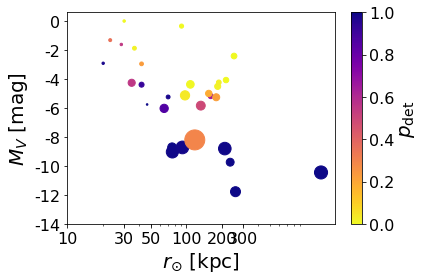

In [21]:
plt.xscale('log')
sc = plt.scatter(MW_r_PS1,MW_Mv_PS1,c=PS1_ssf.predict(distance=MW_r_PS1,abs_mag=MW_Mv_PS1-0.5,
                r_physical=MW_r12_PS1),s=400.*MW_r12_PS1/np.max(MW_r12_PS1),vmin=0.,vmax=1.,cmap='plasma_r')

plt.xticks([10,30,50,100,200,300],[10,30,50,100,200,300],fontsize=16)
plt.yticks([0,-2,-4,-6,-8,-10,-12,-14],[0,-2,-4,-6,-8,-10,-12,-14],fontsize=16)
plt.xlabel(r'$r_{\rm{\odot}}$ [kpc]', size=20)
plt.ylabel(r'$M_V$ [mag]', size=20)   

cbar = plt.colorbar(sc)
cbar.set_label(r'$p_{\rm{det}}$',size=20,labelpad=4)
cbar.set_ticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.tick_params(labelsize=16) 

plt.tight_layout()
plt.show()

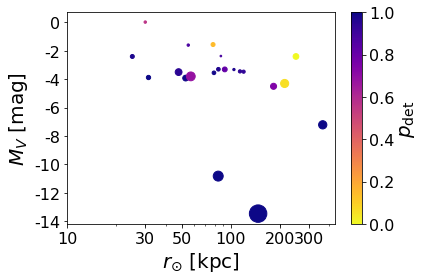

In [13]:
plt.xscale('log')
sc = plt.scatter(MW_r_DES[2:],MW_Mv_DES[2:],c=DES_ssf.predict(distance=MW_r_DES[2:],abs_mag=MW_Mv_DES[2:],
                r_physical=MW_r12_DES[2:]),s=400.*MW_r12_DES[2:]/np.max(MW_r12_PS1),vmin=0.,vmax=1.,cmap='plasma_r')

plt.xticks([10,30,50,100,200,300],[10,30,50,100,200,300],fontsize=16)
plt.yticks([0,-2,-4,-6,-8,-10,-12,-14],[0,-2,-4,-6,-8,-10,-12,-14],fontsize=16)
plt.xlabel(r'$r_{\rm{\odot}}$ [kpc]', size=20)
plt.ylabel(r'$M_V$ [mag]', size=20)   

cbar = plt.colorbar(sc)
cbar.set_label(r'$p_{\rm{det}}$',size=20,labelpad=4)
cbar.set_ticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.tick_params(labelsize=16) 

plt.tight_layout()
plt.show()

In [14]:
pdet_DES = {}
i = 0

for name in DES_dwarfs_confirmed:
    pdet_DES[name] = DES_ssf.predict(lon=MW_ra_DES[i],lat=MW_dec_DES[i],distance=MW_r_DES[i],abs_mag=MW_Mv_DES[i],
                r_physical=MW_r12_DES[i])
    i += 1
    
np.save('pdet_DES.npy', pdet_DES)

In [15]:
pdet_DES = {}
i = 0

for name in DES_dwarfs_confirmed:
    pdet_DES[name] = DES_ssf.predict(lon=MW_ra_DES[i],lat=MW_dec_DES[i],distance=MW_r_DES[i],abs_mag=MW_Mv_DES[i],
                r_physical=MW_r12_DES[i])
    i += 1
    
np.save('pdet_DES.npy', pdet_DES)

In [16]:
pdet_DES

{'Cetus II': array([0.56127828]),
 'Columba I': array([0.74342743]),
 'Eridanus II': array([0.99934164]),
 'Eridanus III': array([0.88603833]),
 'Fornax': array([0.99999647]),
 'Grus I': array([0.9347547]),
 'Grus II': array([0.9948097]),
 'Horologium I': array([0.98896752]),
 'Horologium II': array([0.14471132]),
 'Large Magellanic Cloud': array([0.98008917]),
 'Phoenix II': array([0.96892825]),
 'Pictor I': array([0.94358929]),
 'Reticulum II': array([0.99902571]),
 'Sculptor': array([0.99999766]),
 'Small Magellanic Cloud': array([0.99992183]),
 'Tucana II': array([0.68571323]),
 'Tucana III': array([0.97272072]),
 'Tucana IV': array([0.95221254]),
 'Tucana V': array([0.87578527])}

In [19]:
pdet_PS1 = {}
j = 0

for name in PS1_sats_all:
    pdet_PS1[name] = PS1_ssf.predict(distance=MW_r_PS1[j],abs_mag=MW_Mv_PS1[j]-0.5,
                r_physical=MW_r12_PS1[j])
    j += 1
    
np.save('pdet_PS1.npy', pdet_PS1)

In [20]:
pdet_PS1

{'Antlia': array([0.99931924]),
 'Aquarius II': array([0.00639345]),
 'Bootes I': array([0.85966664]),
 'Bootes II': array([0.22991342]),
 'Bootes III': array([0.99910082]),
 'Canes Venatici I': array([0.99555208]),
 'Canes Venatici II': array([0.64968246]),
 'Cetus II': array([0.0022458]),
 'Cetus III': array([1.66017217e-05]),
 'Columba I': array([0.01569451]),
 'Coma Berenices I': array([0.91852995]),
 'Crater II': array([0.29479302]),
 'Draco': array([0.99777244]),
 'Draco II': array([0.98159933]),
 'Hercules I': array([0.49424134]),
 'Leo I': array([0.99982831]),
 'Leo II': array([0.99950425]),
 'Leo IV': array([0.18704084]),
 'Leo V': array([0.22545383]),
 'Pegasus III': array([0.00265141]),
 'Pisces II': array([0.02315624]),
 'Sagittarius II': array([0.9830014]),
 'Segue 1': array([0.35873718]),
 'Segue 2': array([0.01694759]),
 'Sextans': array([0.99217017]),
 'Triangulum II': array([0.54663494]),
 'Ursa Major I': array([0.03847134]),
 'Ursa Major II': array([0.55270589]),
 'Ur